<a href="https://colab.research.google.com/github/sapto-nugroho/PCD/blob/main/PCD_Assignment02/PCD_Assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##
Implementing following program from scratch

1. Convolution Function

2. Spatial Filtering with several kernel and discuss in which image case the kernel is suitable for

3. Sharpening with blurring operation

4. Make discussion in the end of COLAB, in which case the filtering should be used instead of pixel-based method.

Create your notebook with name as "PCD_Assignment02" and upload to GitHub. You need to provide your GitHub's code link to the text editor in submission form.

## Import

In [1]:
!ls
!git clone https://github.com/sapto-nugroho/PCD.git
!ls

sample_data
Cloning into 'PCD'...
remote: Enumerating objects: 376, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 376 (delta 43), reused 5 (delta 2), pack-reused 200 (from 1)
Receiving objects: 100% (376/376), 11.45 MiB | 27.32 MiB/s, done.
Resolving deltas: 100% (112/112), done.
PCD  sample_data


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import copy

##Image Acquire

In [115]:
def Acquire(src,size):
  #Image and Copy
  img = cv2.imread(src)
  img_copy = copy.deepcopy(img)

  #Plot Image dan Copy
  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img)
  axs[0].set_title(f"Original, shape, {img.shape}")
  axs[1].imshow(img_copy)
  axs[1].set_title(f"Copy, shape {img_copy.shape}")
  plt.tight_layout()
  plt.show()

  return img, img_copy

##main

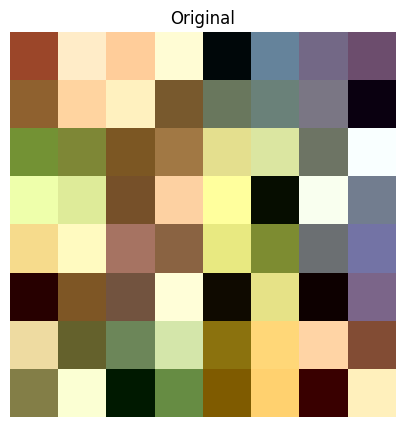

In [155]:
# img_path = '/content/PCD/PCD_Assignment02/images/4x4colour.jpg'
img_path = '/content/PCD/PCD_Assignment02/images/8x8colour.jpg'
# img_path = '/content/PCD/PCD_Assignment02/images/woman01.png'
# img_path = '/content/PCD/PCD_Assignment02/images/pattern.png'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.show()

### Kernel

####custom kernel

In [144]:
kernel1 = np.array([[0,0,0],[0,1,0],[0,0,0]])
kernel2 = np.array([[1,1,1],[1,1,1],[1,1,1]])*(1/9)
kernel3 = np.array([[0,0,0],[0,0,1],[0,0,0]])

#### mean kernel

In [158]:
#membuat kernel mean ukuran nxn
def mean_kernel(size):
  kernel = np.ones((size, size), dtype=float) / (size * size)
  return kernel

### fungsi konvolusi

In [159]:
def konvolusi(img,kernel):

  ksize = kernel.shape[0]
  pad = ksize // 2
  output = np.zeros_like(img, dtype=float)

  for c in range(3):
      padded = np.pad(img[:,:,c], pad, mode='constant')
      for i in range(img.shape[0]):      # baris
          for j in range(img.shape[1]):  # kolom
              region = padded[i:i+ksize, j:j+ksize]
              val = float(np.sum(region * kernel))
              output[i, j, c] = val

  return output.astype(np.uint8)


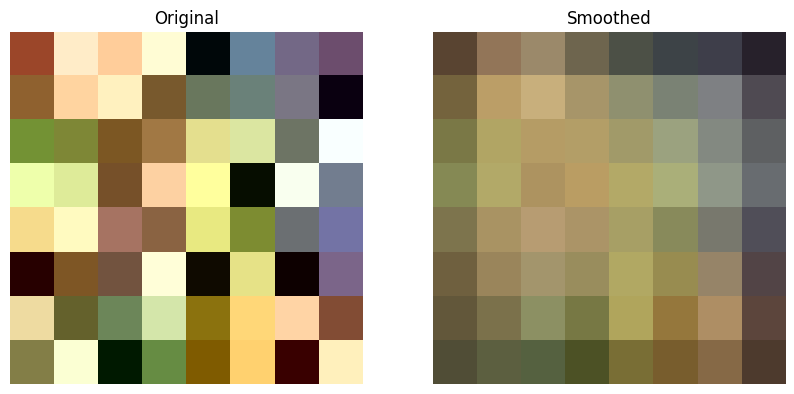

In [160]:

output = konvolusi(img, mean_kernel(3))
# output = konvolusi(img, kernel1)
# output = konvolusi(img, kernel2)
# output = konvolusi(img, kernel3)

#Plotting
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(output)
plt.title("Smoothed")
plt.axis("off")

plt.show()

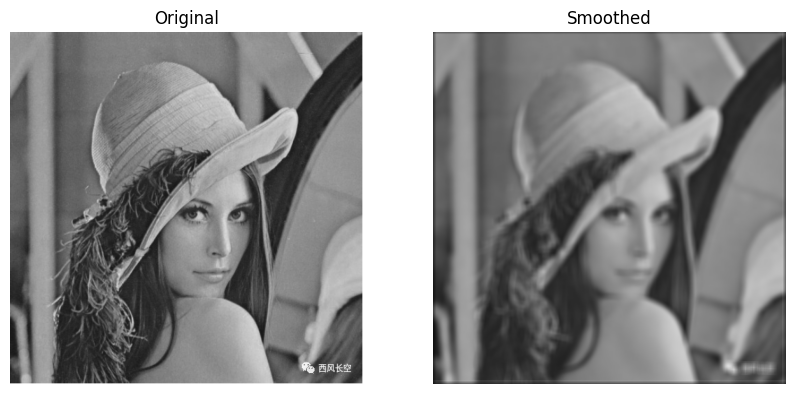

In [109]:

def mean_smoothing(img, ksize):

  #kernel mean (ksize x ksize)
  kernel = np.ones((ksize, ksize), dtype=float) / (ksize * ksize)
  # kernel = np.ones((ksize, ksize), dtype=int) / (ksize * ksize)

  pad = ksize // 2
  output = np.zeros_like(img, dtype=float)
  # output = np.zeros_like(img, dtype=int)

  # Process tiap channel(R, G, B)
  for c in range(3):
      padded = np.pad(img[:,:,c], pad, mode='constant')
      for i in range(img.shape[0]):      # baris
          for j in range(img.shape[1]):  # kolom
              region = padded[i:i+ksize, j:j+ksize]
              value = float(np.sum(region * kernel))
              output[i, j, c] = value

  return output.astype(np.uint8)


img = cv2.imread(img_path)
# print(img.shape)
# print(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB
# print(img.shape)
# print(img)

img_smooth = mean_smoothing(img, 11)

#Plotting
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_smooth)
plt.title("Smoothed")
plt.axis("off")

plt.show()

In [ ]:
def func_convolution(img_,kernel):
  if img_copy.dtype != np.uint8:
    img_ = img_*255
    img_ = img_.astype(np.uint8)

  img_ = img_.astype(int)

  bgr = []
  if img_.shape[2] == 4:
    b,g,r,a = cv2.split(img_)
    bgr.append(b)
    bgr.append(g)
    bgr.append(r)
    bgr.append(a)
  else:
    b,g,r = cv2.split(img_)
    bgr.append(b)
    bgr.append(g)
    bgr.append(r)

  bgr_pad = []
  for i in range(3):
    # bgr_pad = np.pad(b, pad_width=((1, 1), (1, 1)), mode='constant', constant_values=0)
    bgr_pad.append(np.pad(bgr[i], pad_width=2, mode='constant', constant_values=0))
    # print(bgr_pad)

  # img_new = np.zeros((3,b.shape[0],b.shape[1])).astype(np.uint8)
  img_new = np.zeros((3,b.shape[0],b.shape[1])).astype(int)
  # print(img_new.shape)

  for h in range(3):
    for i in range(b.shape[0]):
      for j in range(b.shape[1]):
        img_new[h][i][j] = (kernel1[0][0]*bgr_pad[h][i][j]+kernel1[0][1]*bgr_pad[h][i][j+1]+kernel1[0][2]*bgr_pad[h][i][j+2])+(kernel1[1][0]*bgr_pad[h][i+1][j]+kernel1[1][1]*bgr_pad[h][i+1][j+1]+kernel1[1][2]*bgr_pad[h][i+1][j+2])+(kernel1[2][0]*bgr_pad[h][i+2][j]+kernel1[2][1]*bgr_pad[h][i+2][j+1]+kernel1[2][2]*bgr_pad[h][i+2][j+2])

  img_co = cv2.merge([img_new[0],img_new[1],img_new[2]])
  # img_co = cv2.merge([img_new[2],img_new[1],img_new[0]])
  img_co = img_co.astype(np.uint8)

  # plt.figure(figsize=(10, 10))
  plt.imshow(img_co)
  plt.show()

  return img_co

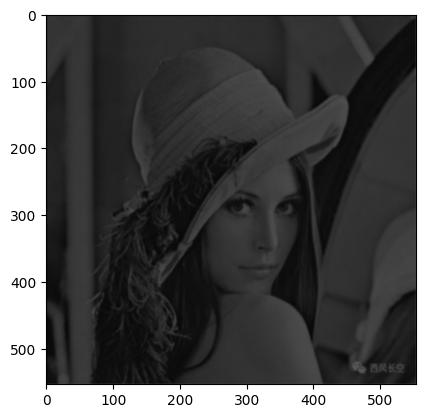

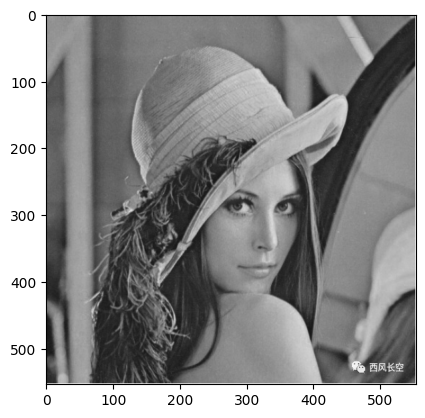

In [ ]:
# kernel1 = np.array([[0,0,0],[0,1,0],[0,0,0]])
# kernel1 = np.array([[1,1,1],[1,1,1],[1,1,1]])*(1/9)
# kernel1 = np.array([[1,2,1],[2,4,2],[1,2,1]])*(1/16)
kernel1 = np.array([[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])*(1/25)
# kernel1 = np.array([[1,2,3,2,1],[1,2,3,2,1],[1,2,3,2,1],[1,2,3,2,1],[1,2,3,2,1]])*(1/25)


output = func_convolution(img_copy,kernel1)
# plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

#JUNK

In [ ]:
import cv2
import numpy as np

def smoothing(img, ksize=11):
    # Create averaging kernel (ksize x ksize)
    kernel = np.ones((ksize, ksize), dtype=float) / (ksize * ksize)

    # Amount of padding
    pad = ksize // 2
    padded = np.pad(img, pad, mode='edge')

    # Output image
    output = np.zeros_like(img, dtype=float)

    # Manual convolution
    for i in range(img.shape[0]):      # rows
        for j in range(img.shape[1]):  # cols
            region = padded[i:i+ksize, j:j+ksize]
            value = float(np.sum(region * kernel))   # ensure scalar, not array
            output[i, j] = value

    return output.astype(np.uint8)

# === Example usage ===
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_smooth = smoothing(img, ksize=21)


# Show with matplotlib
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_smooth, cmap="gray")
plt.title("Smoothed (11x11)")
plt.axis("off")

plt.show()

In [ ]:
# x = np.array([[1,2,3],[4,5,6],[7,8,9]])
# print(x)
# padded = np.pad(x, 2, mode='constant')
# print(padded)

img = cv2.imread(img_path)   # read BGR
print(img)
print(img[:,:,1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB
# print(img[0][0])

[[[ 41   0   0]
  [130  86  79]
  [156 209 252]
  [  0   0  36]]

 [[ 72  28  21]
  [240 196 189]
  [ 93 146 189]
  [ 33  86 129]]

 [[114 221 255]
  [  0  84 118]
  [  5   0  25]
  [155 138 175]]

 [[ 49 156 190]
  [117 224 255]
  [ 87  70 107]
  [209 192 229]]]
[[  0  86 209   0]
 [ 28 196 146  86]
 [221  84   0 138]
 [156 224  70 192]]
